In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-22 20:39:15 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-22 20:39:16 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-22 20:39:16 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-22 20:39:19 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-22 20:39:19 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-22 20:39:19 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-22 20:39:19 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-22 20:39:20 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-22 20:39:20 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-09-22 20:39:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-22 20:39:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-22 20:39:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-22 20:40:11 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-22 20:40:11 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-22 20:40:11 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

select_task.filter_single_token(tokenizer=mt.tokenizer, prefix=" ")

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(10), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Peach -> Strawberry (2): ['Ottoman', 'Gloves', 'Strawberry', 'Razor', 'Folder', 'Shower']
Options: Ottoman, Gloves, Strawberry, Razor, Folder, Shower.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Ottoman, Gloves, Strawberry, Razor, Folder, Shower.
Which among these objects mentioned above is a fruit?
Answer:" >> Strawberry


(True,
 [PredictedToken(token=' Strawberry', prob=0.69140625, logit=21.125, token_id=89077, metadata=None),
  PredictedToken(token=' The', prob=0.13671875, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0732421875, logit=18.875, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.044189453125, logit=18.375, token_id=362, metadata=None),
  PredictedToken(token=' strawberry', prob=0.00872802734375, logit=16.75, token_id=73700, metadata=None)],
 OrderedDict([(89077,
               (1,
                PredictedToken(token=' Strawberry', prob=0.69140625, logit=21.125, token_id=89077, metadata=None))),
              (48471,
               (75,
                PredictedToken(token=' Shower', prob=5.173683166503906e-05, logit=11.625, token_id=48471, metadata=None))),
              (70110,
               (86,
                PredictedToken(token=' Ottoman', prob=3.790855407714844e-05, logit=11.3125, token_id=70110, metadata=None))),
           

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Strawberry. Strawberry is a fruit. The other options are not fruits. Ottoman is a piece of furniture" >> Strawberry


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


2025-09-22 20:40:56 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-22 20:40:56 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-22 20:40:56 matplotlib DEBUG    interactive is False
2025-09-22 20:40:56 matplotlib DEBUG    platform is linux
2025-09-22 20:40:57 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-22 20:40:57 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-22 20:40:57 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-22 20:40:57 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-22 20:40:57 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-22 20:40:57 matplotlib.font

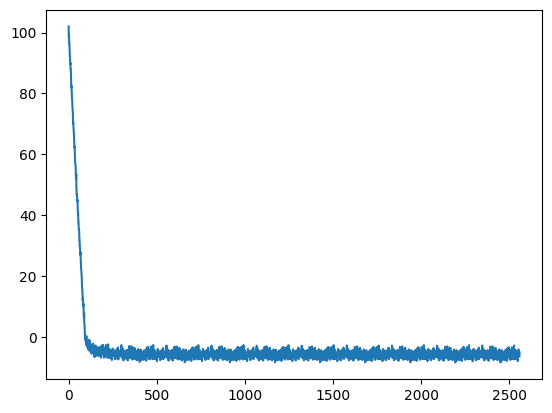

In [12]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


(True, True)

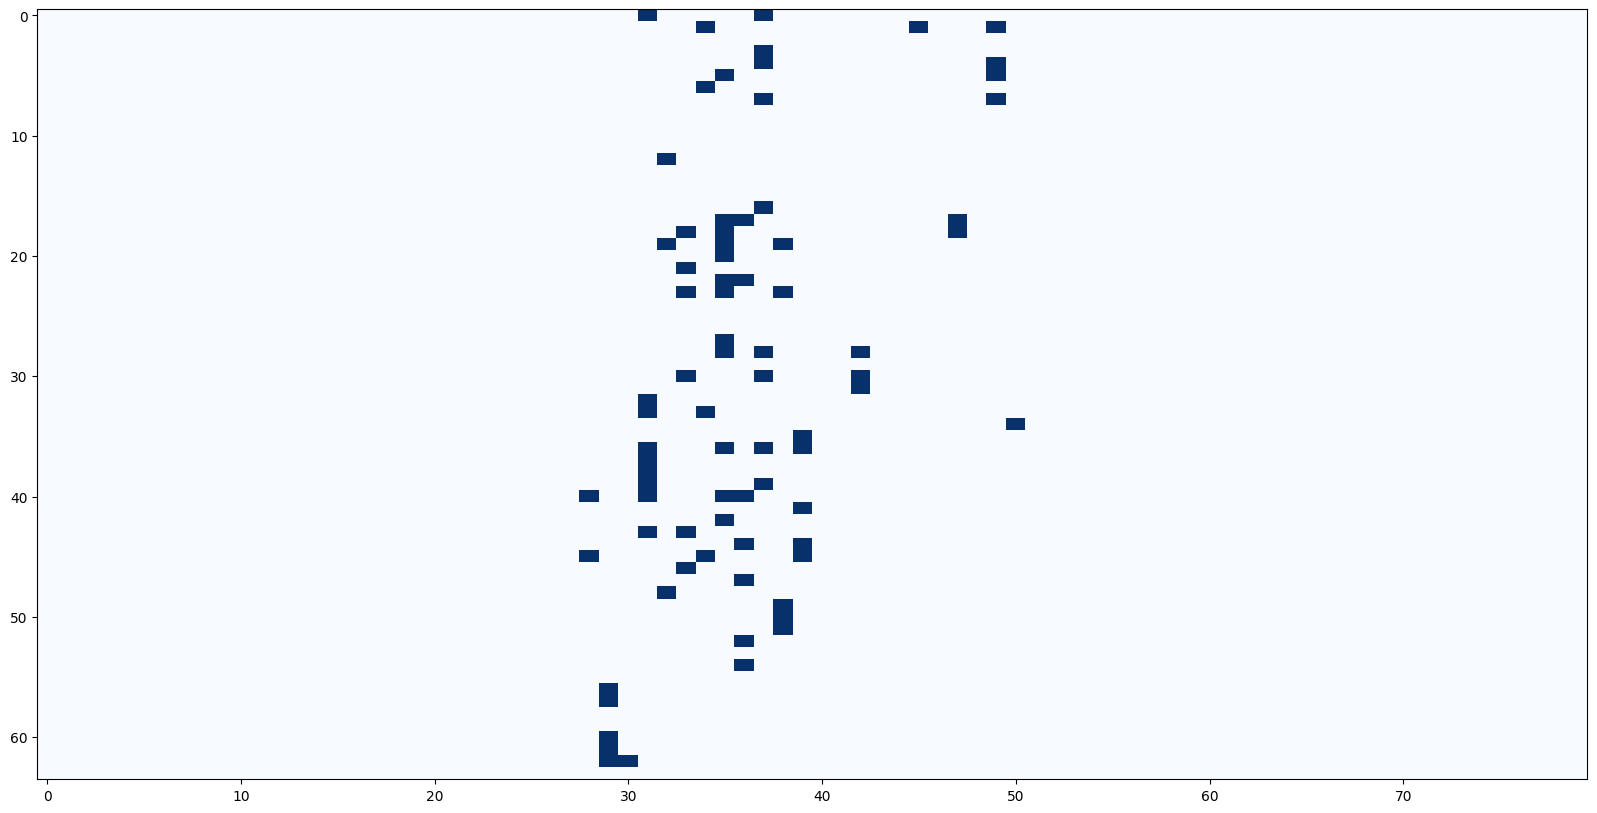

In [13]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [14]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

2025-09-22 20:41:01 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.691, logit=21.125)', '" The"[578] (p=0.137, logit=19.500)', '" Among"[22395] (p=0.073, logit=18.875)', '" A"[362] (p=0.044, logit=18.375)', '" strawberry"[73700] (p=0.009, logit=16.750)']
2025-09-22 20:41:01 src.selection.functional INFO     Combined attention matrix for all heads


In [15]:
from src.selection.data import get_counterfactual_samples_within_task

patch_sample, clean_sample = get_counterfactual_samples_within_task(
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    n_distractors=5,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

clean_sample.metadata

2025-09-22 20:41:03 src.selection.data INFO     clean_obj_idx=1 | ['Laptop', 'Bus', 'Oven', 'Sheep', 'Notebook', 'Apple']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-22 20:41:03 src.selection.data INFO     Options: Watch, Dog, Raspberry, Shirt, Tape, Van.
Which among these objects mentioned above is a fruit?
Answer:
2025-09-22 20:41:03 src.selection.data INFO     Orange | fruit -> Raspberry | pred=['" Raspberry"[48665] (p=0.715, logit=21.250)', '" The"[578] (p=0.109, logit=19.375)', '" Among"[22395] (p=0.085, logit=19.125)', '" A"[362] (p=0.024, logit=17.875)', '" R"[432] (p=0.017, logit=17.500)']
2025-09-22 20:41:03 src.selection.data INFO     Options: Laptop, Bus, Oven, Sheep, Notebook, Apple.
Which among these objects mentioned above is a vehicle?
Answer:
2025-09-22 20:41:03 src.selection.data INFO     Bike | vehicle -> Bus | pred=['" Bus"[19111] (p=0.766, logit=22.375)', '" The"[578] (p=0.104, logit=20.375)', '" Among"[22395] (p=0.049, logit=19.625)', '" A"[362] (p=0.049, logit=19.625)', '" It"[1102] (p=0.007, logit=17.625)']
2025-09-22 20:41:03 src.selection.data INFO     Options: L

{'track_category': 'fruit',
 'track_type_obj': 'Apple',
 'track_type_obj_idx': 5,
 'track_type_obj_token_id': 8325,
 'ques_pos': 24,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  57225,     11,  19111,     11,  87213,     11,
            84008,     11,  69755,     11,   8325,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [46]:
from src.functional import generate_with_patch
from src.selection.utils import get_first_token_id
from src.selection.data import MCQify_sample

mt.reset_forward()
mt.set_attn_implementation("eager")

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
patch_sample.options = ["Cherry", "Knife", "Pen", "Ambulance"]
# patch_sample.options = ["Ferry", "Knife", "Pen", "Ambulance"]
# patch_sample.options = ["#"]

clean_sample.options = ["Binder", "Peach", "Watch", "Scooter", "Phone"]
clean_sample.metadata = {
    "track_category": "fruit",
    "track_type_obj": "Peach",
    "track_type_obj_idx": 1,
    "track_type_obj_token_id": get_first_token_id(tokenizer=mt.tokenizer, name="Peach", prefix=" ")
}
clean_sample.obj_idx = 3
clean_sample.obj = "Scooter"
clean_sample.ans_token_id = get_first_token_id(tokenizer=mt.tokenizer, name="Scooter", prefix=" ")

clean_sample.prompt_template = "<_options_>\nFind the <_category_> in the list.\nAnswer:"
patch_sample.prompt_template = "<_options_>\nFind the <_category_> in the list.\nAnswer:"

clean_sample = MCQify_sample(sample=clean_sample, tokenizer=mt.tokenizer)
# clean_sample.default_option_style = "bulleted"

for sample in [patch_sample, clean_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        # heads=HEADS,
        heads=[(35, 19)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Cherry, Knife, Pen, Ambulance.
Find the fruit in the list.
Answer: >> Raspberry
2025-09-22 20:49:34 src.selection.functional DEBUG    Predictions: ['" Cherry"[45805] (p=0.750, logit=22.125)', '" The"[578] (p=0.215, logit=20.875)', '" CH"[6969] (p=0.007, logit=17.375)', '" A"[362] (p=0.005, logit=17.125)', '" There"[2684] (p=0.005, logit=17.125)']
2025-09-22 20:49:34 src.selection.functional INFO     Combined attention matrix for all heads


a. Binder
b. Peach
c. Watch
d. Scooter
e. Phone
Find the vehicle in the list.
Answer: >> Scooter
2025-09-22 20:49:35 src.selection.functional DEBUG    Predictions: ['" d"[294] (p=0.730, logit=21.375)', '" The"[578] (p=0.099, logit=19.375)', '" Sco"[50159] (p=0.047, logit=18.625)', '" ("[320] (p=0.041, logit=18.500)', '" A"[362] (p=0.028, logit=18.125)']
2025-09-22 20:49:35 src.selection.functional INFO     Combined attention matrix for all heads


In [47]:
from src.selection.functional import cache_q_projections
from src.functional import PatchSpec
from src.tokens import prepare_input

mt.reset_forward()
mt.set_attn_implementation("eager")
#####################################################
query_indices = {-3: -3, -2: -2, -1: -1}
#####################################################

clean_tokenized = prepare_input(
    prompts=clean_sample.prompt(), 
    tokenizer=mt.tokenizer,
    return_offsets_mapping=True
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]

patch_tokenized = prepare_input(
    prompts=patch_sample.prompt(), 
    tokenizer=mt.tokenizer,
    return_offsets_mapping=True
)
patch_offsets = patch_tokenized.pop("offset_mapping")[0]

cached_q_states, patch_output = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    # heads=[(35, 19)],
    heads = optimized_heads,
    token_indices=[[-3, -2, -1]],
    return_output=True,
)

q_proj_patches = []
for (layer_idx, head_idx, patch_query_idx), q_proj in cached_q_states[0].items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_indices[patch_query_idx],
            ),
            patch=q_proj,
        )
    )

attn_pattern = verify_head_patterns(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=HEADS,
    # heads=optimized_heads,
    heads=[(35, 19)],
    query_index=-1,
    query_patches=q_proj_patches
)

2025-09-22 20:49:36 src.selection.functional DEBUG    Predictions: ['" b"[293] (p=0.699, logit=21.625)', '" Peach"[64695] (p=0.200, logit=20.375)', '" The"[578] (p=0.045, logit=18.875)', '" Option"[7104] (p=0.015, logit=17.750)', '" ("[320] (p=0.013, logit=17.625)']
2025-09-22 20:49:36 src.selection.functional INFO     Combined attention matrix for all heads


In [48]:
# clean_sample.obj, clean_sample.metadata['track_type_obj']
from src.tokens import find_token_range
import random

# random_target = random.choice(
#     list(
#         set(clean_sample.options)
#         - {clean_sample.obj, clean_sample.metadata["track_type_obj"]}
#     )
# )
random_target = "Phone"
logger.debug(f"Random target: {random_target}")

patch_type_obj_token_idx = (
    find_token_range(
        string=clean_sample.prompt(),
        substring=clean_sample.metadata["track_type_obj"],
        # substring=clean_sample.obj,
        offset_mapping=clean_offsets,
    )[1]
    - 1
)
logger.debug(
    f'{patch_type_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][patch_type_obj_token_idx])}"'
)

target_obj_token_idx = (
    find_token_range(
        string=clean_sample.prompt(),
        substring=random_target,
        offset_mapping=clean_offsets,
    )[1]
    - 1
)
logger.debug(
    f'{target_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][target_obj_token_idx])}"'
)

2025-09-22 20:49:39 __main__ DEBUG    Random target: Phone
2025-09-22 20:49:39 __main__ DEBUG    patch_type_obj_token_idx=7 | " Peach"
2025-09-22 20:49:39 __main__ DEBUG    target_obj_token_idx=20 | " Phone"


In [49]:
# import nnsight
# with mt.trace("hello") as tracer:
#     hs = mt.model.layers[-1].output[0]
#     tracer.log(hs[0,0,0])
#     out =  mt.lm_head.output.save()

# print(out)

In [50]:
len(optimized_heads)

79

In [51]:
from src.selection.functional import cache_q_projections

key_indices = {
    patch_type_obj_token_idx: target_obj_token_idx,
    target_obj_token_idx: patch_type_obj_token_idx,
    patch_type_obj_token_idx + 1: target_obj_token_idx + 1,
    target_obj_token_idx + 1: patch_type_obj_token_idx + 1,
}

key_locations = [
    (layer_idx, head_idx, patch_key_idx)
    for layer_idx, head_idx in HEADS
    # for layer_idx, head_idx in [(35, 19)]
    for patch_key_idx in key_indices.keys()
]

cached_k_states = cache_q_projections(
    mt=mt,
    input=clean_tokenized, #! should always be clean_tokenized
    token_indices=[list(key_indices.keys())],
    heads=optimized_heads,
    return_output=False,
    projection_signature=".k_proj",
)[0]

k_proj_patches = []
for (layer_idx, head_idx, patch_key_idx), k_proj in cached_k_states.items():
    k_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".k_proj",
                head_idx,
                key_indices[patch_key_idx],
            ),
            patch=k_proj,
        )
    )

In [52]:
import math
from src.functional import get_module_nnsight, repeat_kv
from src.attention import visualize_attn_matrix
from src.hooking.llama_attention import apply_rotary_pos_emb

layer_idx, head_idx = (35, 19)
with mt.trace(clean_tokenized) as tracer:
    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.save()
    # tracer.log(patch_q_proj.shape)

    k_proj_name = mt.attn_module_name_format.format(layer_idx) + ".k_proj"
    k_proj_module = get_module_nnsight(mt, k_proj_name)
    clean_k_proj = k_proj_module.output.save()
    # tracer.log(patch_k_proj.shape)

query = clean_q_proj
key = clean_k_proj
print(f"{query.shape=}, {key.shape=}")

batch_size = clean_tokenized.input_ids.shape[0]
seq_len = clean_tokenized.input_ids.shape[1]
n_heads = mt.config.num_attention_heads
n_kv_heads = mt.config.num_key_value_heads
head_dim = mt.n_embd // n_heads
key = key.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)
query = query.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)

key = repeat_kv(key, n_rep=n_heads // n_kv_heads)
print(f"{query.shape=}, {key.shape=}")


############## intervention ##############
source_token_id = patch_type_obj_token_idx
key_source = key[:, head_idx, source_token_id].clone()

target_token_id = target_obj_token_idx
key_target = key[:, head_idx, target_token_id].clone()

# key[:, head_idx, source_token_id, :] = key_target
# key[:, head_idx, target_token_id, :] = key_source
key[:, head_idx, source_token_id, :] = cached_k_states[(layer_idx, head_idx, target_token_id)]
key[:, head_idx, target_token_id, :] = cached_k_states[(layer_idx, head_idx, source_token_id)]
############## intervention ##############


scale_factor = 1 / math.sqrt(query.size(-1))
L, S = query.size(-2), key.size(-2)
attn_bias = torch.zeros(L, S, dtype=query.dtype)
temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
attn_bias.to(query.dtype)

attn_weight = query @ key.transpose(-2, -1) * scale_factor
attn_weight += attn_bias.to(attn_weight.dtype).to(attn_weight.device)
attn_weight = torch.softmax(attn_weight, dim=-1)

head_matrix = attn_weight[0, head_idx].squeeze()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]]
)

query.shape=torch.Size([1, 31, 8192]), key.shape=torch.Size([1, 31, 1024])
query.shape=torch.Size([1, 64, 31, 128]), key.shape=torch.Size([1, 64, 31, 128])


In [53]:
# torch.allclose(
#     cached_k_states[(layer_idx, head_idx, source_token_id)],
#     key_source,
#     atol=1e-3
# )

In [54]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean_sample,
    patch_sample=patch_sample,
    heads=optimized_heads,
    query_indices={tok_idx: tok_idx for tok_idx in range(-10, 0)},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
    # patch_args={
    #     "batch_size": N_DISTRACTORS + 1,
    #     "task": select_task,
    #     "prompt_template_idx": prompt_template_idx,
    #     "option_style": patch.default_option_style,
    #     "distinct_options": False,
    #     "n_distractors": N_DISTRACTORS,
    # },
)

2025-09-22 20:49:42 src.selection.optimization INFO     Verifying head behavior...
2025-09-22 20:49:42 src.selection.optimization INFO     Clean Sample >> Ans:  d


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-22 20:49:47 src.selection.functional DEBUG    Generated full answer: " d. Scooter
Explanation: A scooter is a vehicle, while the other options are not. A binder is a type of notebook, a peach"
2025-09-22 20:49:47 src.selection.functional DEBUG    Predictions: ['" d"[294] (p=0.730, logit=21.375)', '" The"[578] (p=0.099, logit=19.375)', '" Sco"[50159] (p=0.047, logit=18.625)', '" ("[320] (p=0.041, logit=18.500)', '" A"[362] (p=0.028, logit=18.125)']
2025-09-22 20:49:47 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-22 20:49:47 src.selection.optimization INFO     Patch Sample >> Ans:  Raspberry


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-22 20:49:52 src.selection.functional DEBUG    Generated full answer: " Cherry. It is the only fruit in the list. The other options are an object, a writing instrument, and a vehicle."
2025-09-22 20:49:52 src.selection.functional DEBUG    Predictions: ['" Cherry"[45805] (p=0.750, logit=22.125)', '" The"[578] (p=0.215, logit=20.875)', '" CH"[6969] (p=0.007, logit=17.375)', '" A"[362] (p=0.005, logit=17.125)', '" There"[2684] (p=0.005, logit=17.125)']
2025-09-22 20:49:52 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-22 20:49:52 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-22 20:49:52 src.selection.optimization INFO     patch_prediction=['" Cherry"[45805] (p=0.750, logit=22.125)', '" The"[578] (p=0.215, logit=20.875)', '" CH"[6969] (p=0.007, logit=17.375)', '" There"[2684] (p=0.005, logit=17.125)', '" A"[362] (p=0.005, logit=17.125)']
2025-09-22 20:49:52 src.selection.optimization INFO     clean run
2025-09-22 20:49:53 src.selection.optimization INFO     clean_prediction=['" d"[294] (p=0.730, logit=21.375)', '" The"[578] (p=0.099, logit=19.375)', '" Sco"[50159] (p=0.047, logit=18.625)', '" ("[320] (p=0.041, logit=18.500)', '" A"[362] (p=0.028, logit=18.125)']
2025-09-22 20:49:53 src.selection.optimization INFO     clean_track=OrderedDict([(294, (1, PredictedToken(token=' d', prob=0.73046875, logit=21.375, token_id=294, metadata=None))), (264, (7, PredictedToken(token=' a', prob=0.00433349609375, logit=16.25, token_id=264, metadata=None))), (293, (8, 

2025-09-22 20:49:53 src.selection.optimization INFO     int_prediction=['" b"[293] (p=0.578, logit=21.250)', '" Peach"[64695] (p=0.309, logit=20.625)', '" The"[578] (p=0.054, logit=18.875)', '" Option"[7104] (p=0.015, logit=17.625)', '" ("[320] (p=0.014, logit=17.500)']
2025-09-22 20:49:53 src.selection.optimization INFO     int_track=OrderedDict([(293, (1, PredictedToken(token=' b', prob=0.578125, logit=21.25, token_id=293, metadata=None))), (384, (7, PredictedToken(token=' e', prob=0.0038909912109375, logit=16.25, token_id=384, metadata=None))), (264, (8, PredictedToken(token=' a', prob=0.0026702880859375, logit=15.875, token_id=264, metadata=None))), (272, (10, PredictedToken(token=' c', prob=0.0012664794921875, logit=15.125, token_id=272, metadata=None))), (294, (15, PredictedToken(token=' d', prob=0.00081634521484375, logit=14.6875, token_id=294, metadata=None)))])


In [55]:
from src.utils.typing import TokenizerOutput
from src.functional import interpret_logits, patch_with_baukit
from src.attention import visualize_attn_matrix, visualize_average_attn_matrix
import baukit
from src.hooking.llama_attention import LlamaAttentionPatcher
import types


def verify_head_patterns_custom_attention(
    prompt: str | TokenizerOutput,
    options: list[str],
    pivot: str,
    mt: ModelandTokenizer,
    heads: list[tuple[int, int]],
    tokenized_prompt: TokenizerOutput | None = None,
    visualize_individual_heads: bool = False,
    value_weighted: bool = False,
    ablate_possible_ans_info_from_options: bool = False,
    bare_prompt_template=" The fact that {}",
    query_index: int = -1,
    query_patches: list[PatchSpec] = [],
    key_patches: list[PatchSpec] = [],
    start_from: int = 1,
):
    tokenized_prompt = (
        prepare_input(
            tokenizer=mt,
            prompts=prompt,
            return_offsets_mapping=True,
        )
        if tokenized_prompt is None
        else tokenized_prompt
    )
    patches = (
        get_patches_to_verify_independent_enrichment(
            prompt=prompt,
            options=options,
            pivot=pivot,
            mt=mt,
            tokenized_prompt=tokenized_prompt,
            bare_prompt_template=bare_prompt_template,
        )
        if ablate_possible_ans_info_from_options
        else []
    )
    patches = patches + query_patches
    print(len(patches), "patches to ablate possible answer information from options")

    ################## inference with intervention #######################
    ret_dict = {}
    default_attn_implementation = mt.config._attn_implementation
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")
    layers_to_heads = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)

    layers_to_q_patches = {}
    for patch in query_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        patch_rep = patch.patch
        if layer_idx not in layers_to_q_patches:
            layers_to_q_patches[layer_idx] = []
        layers_to_q_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    layers_to_k_patches = {}
    for patch in key_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        patch_rep = patch.patch
        if layer_idx not in layers_to_k_patches:
            layers_to_k_patches[layer_idx] = []
        layers_to_k_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    attention_patterns = {}
    head_contributions = {}
    for layer_idx, head_indices in layers_to_heads.items():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attention_patterns[layer_idx] = {}
        # head_contributions[layer_idx] = {}

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=head_indices,
                store_attn_matrices=attention_patterns[layer_idx],
                # store_head_contributions=head_contributions[layer_idx],
                query_patches=layers_to_q_patches[layer_idx] if layer_idx in layers_to_q_patches else [],
                key_patches=layers_to_k_patches[layer_idx] if layer_idx in layers_to_k_patches else [],
                value_weighted=value_weighted,
            ),
            attn_block,
        )
    patches = []  # q_proj_patches are handled by hooking the default forward pass

    if ablate_possible_ans_info_from_options:
        patches.extend(
            get_patches_to_verify_independent_enrichment(
                prompt=clean_sample.prompt(),
                options=clean_sample.options,
                pivot=clean_sample.subj,
                mt=mt,
                tokenized_prompt=clean_tokenized,
            )
        )
    output = patch_with_baukit(
        mt=mt,
        inputs=tokenized_prompt,
        patches=patches,
    )
    logits = output.logits[:, -1, :].squeeze()

    mt.reset_forward()
    mt.set_attn_implementation(default_attn_implementation)
    ################## inference with intervention #######################

    predictions = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=logits,
    )
    logger.debug(f"Predictions: {[str(p) for p in predictions]}")
    ret_dict["predictions"] = predictions
    ret_dict["logits"] = logits
    ret_dict["attn_matrices"] = attention_patterns

    if heads is not None and len(heads) > 0:
        combined = []
        for layer_idx, head_idx in heads:
            head_matrix = torch.Tensor(
                attention_patterns[layer_idx][head_idx].cpu()
            )
            combined.append(head_matrix)
            if visualize_individual_heads:
                logger.info(f"Layer: {layer_idx}, Head: {head_idx}")
                visualize_attn_matrix(
                    attn_matrix=head_matrix,
                    tokens=[mt.tokenizer.decode(t) for t in tokenized_prompt.input_ids[0]],
                    q_index=query_index,
                    start_from=start_from,
                )

        logger.info("Combined attention matrix for all heads")
        combined_matrix = torch.stack(combined).squeeze()
        if combined_matrix.dim() == 3:
            combined_matrix = combined_matrix.mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=combined_matrix,
            tokens=[mt.tokenizer.decode(t) for t in tokenized_prompt.input_ids[0]],
            q_index=query_index,
            start_from=start_from,
        )
    return ret_dict

clean_attn_info = verify_head_patterns_custom_attention(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=optimized_heads,
    heads=[(35, 19)],
    query_index=-1,
)

q_attn_info = verify_head_patterns_custom_attention(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=optimized_heads,
    heads=[(35, 19)],
    query_index=-1,
    query_patches=q_proj_patches,
)

qk_attn_info = verify_head_patterns_custom_attention(
    prompt=clean_sample.prompt(),
    options=clean_sample.options,
    pivot=clean_sample.subj,
    mt=mt,
    # heads=optimized_heads,
    heads=[(35, 19)],
    query_index=-1,
    query_patches=q_proj_patches,
    key_patches=k_proj_patches,
)

0 patches to ablate possible answer information from options
2025-09-22 20:49:58 __main__ DEBUG    Predictions: ['" d"[294] (p=0.695, logit=21.250)', '" The"[578] (p=0.121, logit=19.500)', '" Sco"[50159] (p=0.050, logit=18.625)', '" ("[320] (p=0.044, logit=18.500)', '" A"[362] (p=0.031, logit=18.125)']
2025-09-22 20:49:58 __main__ INFO     Combined attention matrix for all heads


237 patches to ablate possible answer information from options
2025-09-22 20:49:59 __main__ DEBUG    Predictions: ['" d"[294] (p=0.711, logit=21.000)', '" The"[578] (p=0.096, logit=19.000)', '" ("[320] (p=0.040, logit=18.125)', '" b"[293] (p=0.031, logit=17.875)', '" Sco"[50159] (p=0.028, logit=17.750)']
2025-09-22 20:49:59 __main__ INFO     Combined attention matrix for all heads


237 patches to ablate possible answer information from options
2025-09-22 20:49:59 __main__ DEBUG    Predictions: ['" d"[294] (p=0.777, logit=21.500)', '" The"[578] (p=0.056, logit=18.875)', '" Sco"[50159] (p=0.050, logit=18.750)', '" ("[320] (p=0.039, logit=18.500)', '" e"[384] (p=0.021, logit=17.875)']
2025-09-22 20:49:59 __main__ INFO     Combined attention matrix for all heads


In [45]:
clean_tok = get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" ")
q_target = clean_sample.metadata["track_type_obj_token_id"]
kq_target = get_first_token_id(random_target, mt.tokenizer, prefix=" ")

interested_tokens = {
    "clean_obj": clean_tok,
    "q_target": q_target,
    "kq_target": kq_target
}
clean_pred, clean_track = interpret_logits(
    logits=clean_attn_info["logits"],
    tokenizer=mt.tokenizer,
    interested_tokens=list(interested_tokens.values())
)
logger.info(f"clean_pred={[str(pred) for pred in clean_pred]}")
logger.info(f"{clean_track=}")

int_pred, int_track = interpret_logits(
    logits=qk_attn_info["logits"],
    tokenizer=mt.tokenizer,
    interested_tokens=list(interested_tokens.values())
)
logger.info(f"int_pred={[str(pred) for pred in int_pred]}")
logger.info(f"{int_track=}")

print("\n")

for token_type, token_id in interested_tokens.items():
    logger.info(f"{token_type}={token_id}, [\"{mt.tokenizer.decode(token_id)}\"]")
    on_clean = clean_track[token_id]
    on_int = int_track[token_id]
    logger.info(f"Rank: {on_clean[0]} -> {on_int[0]} | Δ={on_int[0] - on_clean[0]}")
    logger.info(f"Logit: {on_clean[1].logit:.4f} -> {on_int[1].logit:.4f} | Δ={on_int[1].logit - on_clean[1].logit:.4f}")
    print("=" * 100)

2025-09-22 20:48:58 __main__ INFO     clean_pred=['" Sco"[50159] (p=0.672, logit=21.125)', '" scooter"[76140] (p=0.170, logit=19.750)', '" The"[578] (p=0.062, logit=18.750)', '" A"[362] (p=0.038, logit=18.250)', '" _"[721] (p=0.011, logit=17.000)']
2025-09-22 20:48:58 __main__ INFO     clean_track=OrderedDict([(50159, (1, PredictedToken(token=' Sco', prob=0.671875, logit=21.125, token_id=50159, metadata=None))), (64695, (74, PredictedToken(token=' Peach', prob=4.744529724121094e-05, logit=11.5625, token_id=64695, metadata=None))), (14642, (97, PredictedToken(token=' Phone', prob=2.6941299438476562e-05, logit=11.0, token_id=14642, metadata=None)))])
2025-09-22 20:48:58 __main__ INFO     int_pred=['" Sco"[50159] (p=0.711, logit=21.000)', '" scooter"[76140] (p=0.109, logit=19.125)', '" The"[578] (p=0.066, logit=18.625)', '" A"[362] (p=0.028, logit=17.750)', '" _"[721] (p=0.013, logit=17.000)']
2025-09-22 20:48:58 __main__ INFO     int_track=OrderedDict([(50159, (1, PredictedToken(token=' 

## Scale up

In [96]:
from src.selection.data import CounterFactualSamplePair, get_counterfactual_samples_interface
from src.functional import free_gpu_cache
import random

select_task.filter_single_token(mt.tokenizer, prefix=" ")

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation_single_token_options",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)
os.makedirs(validation_samples_save_path, exist_ok=True)

free_gpu_cache()
validation_set = []
validation_limit = 768
start_number = 1

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # # n_distractors=N_DISTRACTORS,
        patch_n_distractors=random.choice(range(2, 6)),
        clean_n_distractors=random.choice(range(2, 6)),
        # n_options = random.choice([4, 5, 6, 7])
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(validation_samples_save_path, f"{len(validation_set) + start_number - 1:05d}.json"),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

sample 1 / 768
2025-09-20 17:53:51 src.selection.data INFO     clean_obj_idx=3 | ['Sink', 'Helmet', 'Blender', 'Mushroom']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-20 17:53:51 src.selection.data INFO     Options: Helmet, Razor, Oven, Train, Onion.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-09-20 17:53:51 src.selection.data INFO     Soap | bathroom item -> Razor | pred=['" Razor"[74968] (p=0.707, logit=20.250)', '" None"[2290] (p=0.179, logit=18.875)', '" Helmet"[67629] (p=0.017, logit=16.500)', '" The"[578] (p=0.017, logit=16.500)', '" Sh"[1443] (p=0.009, logit=15.875)']
2025-09-20 17:53:51 src.selection.data INFO     Options: Sink, Helmet, Blender, Mushroom.
Which among these objects mentioned above is a vegetable?
Answer:
2025-09-20 17:53:51 src.selection.data INFO     Pepper | vegetable -> Mushroom | pred=['" Mushroom"[91297] (p=0.836, logit=20.750)', '" The"[578] (p=0.047, logit=17.875)', '" A"[362] (p=0.032, logit=17.500)', '" N

768

In [98]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 768

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation_single_token_options",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-09-20 18:21:31 __main__ INFO     Found 768 sample files


768

In [100]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)
clean, patch = copy.deepcopy(validation_set[22])

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads=optimized_heads,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    # query_indices = {-idx: -idx for idx in range(1, 6)},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=1.1
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: School, Bat, Oven, Jasmine, Shower.
Which among these objects mentioned above is a flower?
Answer: >> Jasmine
Options: Blender, Rose, Bear, Drum, Ottoman, Razor.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Blender
2025-09-20 18:22:52 src.selection.optimization INFO     Verifying head behavior...
2025-09-20 18:22:52 src.selection.optimization INFO     Clean Sample >> Ans:  Jasmine


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-20 18:22:57 src.selection.functional DEBUG    Generated full answer: " Jasmine. 
Jasmine is a type of flower. The other options are not flowers. School is an educational institution, Bat is an animal, Oven"
2025-09-20 18:22:57 src.selection.functional DEBUG    Predictions: ['" Jasmine"[82452] (p=0.875, logit=22.000)', '" The"[578] (p=0.044, logit=19.000)', '" Among"[22395] (p=0.039, logit=18.875)', '" jasmine"[66909] (p=0.009, logit=17.375)', '" Option"[7104] (p=0.005, logit=16.750)']
2025-09-20 18:22:57 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-20 18:22:57 src.selection.optimization INFO     Patch Sample >> Ans:  Blender


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-20 18:23:02 src.selection.functional DEBUG    Generated full answer: " Blender.
Explanation: Blender is a kitchen appliance used for mixing, pureeing, or emulsifying food and other substances. It is a common appliance"
2025-09-20 18:23:02 src.selection.functional DEBUG    Predictions: ['" Blender"[88668] (p=0.910, logit=21.875)', '" The"[578] (p=0.031, logit=18.500)', '" A"[362] (p=0.013, logit=17.625)', '" Among"[22395] (p=0.011, logit=17.500)', '" blender"[62895] (p=0.003, logit=16.125)']
2025-09-20 18:23:02 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-20 18:23:02 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-20 18:23:02 src.selection.optimization INFO     patch_prediction=['" Blender"[88668] (p=0.910, logit=21.875)', '" The"[578] (p=0.031, logit=18.500)', '" A"[362] (p=0.013, logit=17.625)', '" Among"[22395] (p=0.011, logit=17.500)', '" blender"[62895] (p=0.003, logit=16.125)']
2025-09-20 18:23:02 src.selection.optimization INFO     clean run
2025-09-20 18:23:03 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.875, logit=22.000)', '" The"[578] (p=0.044, logit=19.000)', '" Among"[22395] (p=0.039, logit=18.875)', '" jasmine"[66909] (p=0.009, logit=17.375)', '" Option"[7104] (p=0.005, logit=16.750)']
2025-09-20 18:23:03 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.875, logit=22.0, token_id=82452, metadata=None))), (6150, (114, PredictedToken(token=' School', prob=1.3709068298339844e-05, logit=

2025-09-20 18:23:03 src.selection.optimization INFO     int_prediction=['" Oven"[87213] (p=0.781, logit=21.250)', '" Bat"[16488] (p=0.064, logit=18.750)', '" The"[578] (p=0.044, logit=18.375)', '" Among"[22395] (p=0.039, logit=18.250)', '" An"[1556] (p=0.014, logit=17.250)']
2025-09-20 18:23:03 src.selection.optimization INFO     int_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.78125, logit=21.25, token_id=87213, metadata=None))), (16488, (2, PredictedToken(token=' Bat', prob=0.06396484375, logit=18.75, token_id=16488, metadata=None))), (48471, (27, PredictedToken(token=' Shower', prob=0.000553131103515625, logit=14.0, token_id=48471, metadata=None))), (6150, (78, PredictedToken(token=' School', prob=7.05718994140625e-05, logit=11.9375, token_id=6150, metadata=None))), (82452, (140, PredictedToken(token=' Jasmine', prob=2.014636993408203e-05, logit=10.6875, token_id=82452, metadata=None)))])
2025-09-20 18:23:03 __main__ DEBUG    clean obj:  Jasmine
2025-09-20 18:

In [101]:
from tqdm.auto import tqdm

query_validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    # clean_sample = copy.deepcopy(clean_sample)
    # clean_sample.options = patch_sample.options

    # patch_sample = copy.deepcopy(patch_sample)
    # patch_sample.options = ["#"]
    # patch_sample.prompt_template = "Which among these objects mentioned above is a <_category_>?\nAnswer:"


    # no information from the patch
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    query_validation_results.append(result)
    print("=" * 80)

  0%|          | 0/768 [00:00<?, ?it/s]

2025-09-20 18:23:33 src.selection.optimization INFO     Caching the query states for the 79 heads
2025-09-20 18:23:33 src.selection.optimization INFO     patch_prediction=['" Printer"[47033] (p=0.648, logit=20.625)', '" Watch"[10573] (p=0.088, logit=18.625)', '" The"[578] (p=0.068, logit=18.375)', '" Among"[22395] (p=0.042, logit=17.875)', '" A"[362] (p=0.037, logit=17.750)']
2025-09-20 18:23:33 src.selection.optimization INFO     clean run
2025-09-20 18:23:33 src.selection.optimization INFO     clean_prediction=['" Folder"[36943] (p=0.648, logit=20.375)', '" Router"[10777] (p=0.099, logit=18.500)', '" The"[578] (p=0.088, logit=18.375)', '" A"[362] (p=0.053, logit=17.875)', '" Among"[22395] (p=0.013, logit=16.500)']
2025-09-20 18:23:33 src.selection.optimization INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.6484375, logit=20.375, token_id=36943, metadata=None))), (10777, (2, PredictedToken(token=' Router', prob=0.09912109375, logit=18.5, token_id=

In [103]:
before_intervention = []
after_intervention = []

for intervention_result in query_validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

print("=" * 80)

clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

print("=" * 80)

counter_patch_type_top_option = 0
failed_cases = []
successful_cases = []
for intervention_result in query_validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
        successful_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(query_validation_results)
print(
    f"Counterfactual patching accuracy (w/o avg trick): {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(query_validation_results)})"
)
print(f"Failed: {len(failed_cases)}")

clean_rank_delta: 44.8789 ± 259.8656
target_rank_delta: -177.5469 ± 331.0790
clean_rank_after_intervention: 45.8802 ± 259.8654
target_rank_after_intervention: 2.5299 ± 6.5958
clean_logit_delta: -5.3493 ± 3.3413
target_logit_delta: 7.8713 ± 3.4701
clean_logit_after_intervention: 16.2389 ± 3.3133
target_logit_after_intervention: 19.9342 ± 1.9160
Counterfactual patching accuracy (w/o avg trick): 0.7188 (552/768)
Failed: 216


In [107]:
from typing import Optional, Any
from src.selection.data import SelectionSample


def patched_run_with_custom_attention(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    patches: list[PatchSpec] = [],
    query_patches: list[PatchSpec] = [],
    key_patches: list[PatchSpec] = [],
    return_attention_patterns: bool = False,
    value_weighted: bool = False,
):
    default_attn_implementation = mt.config._attn_implementation
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")
    layers_to_heads = {}
    layers_to_q_patches = {}
    for patch in query_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)
        patch_rep = patch.patch
        if layer_idx not in layers_to_q_patches:
            layers_to_q_patches[layer_idx] = []
        layers_to_q_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    layers_to_k_patches = {}
    for patch in key_patches:
        layer, head_idx, token_idx = patch.location
        layer_idx = int(layer.split(".")[2])
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)
        patch_rep = patch.patch
        if layer_idx not in layers_to_k_patches:
            layers_to_k_patches[layer_idx] = []
        layers_to_k_patches[layer_idx].append((head_idx, token_idx, patch_rep))

    for layer_idx in layers_to_heads:
        layers_to_heads[layer_idx] = list(set(layers_to_heads[layer_idx]))

    attention_patterns = {}
    for layer_idx, head_indices in layers_to_heads.items():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attention_patterns[layer_idx] = {}
        # head_contributions[layer_idx] = {}

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=head_indices,
                store_attn_matrices=attention_patterns[layer_idx],
                # store_head_contributions=head_contributions[layer_idx],
                query_patches=(
                    layers_to_q_patches[layer_idx]
                    if layer_idx in layers_to_q_patches
                    else []
                ),
                key_patches=(
                    layers_to_k_patches[layer_idx]
                    if layer_idx in layers_to_k_patches
                    else []
                ),
                value_weighted=value_weighted,
            ),
            attn_block,
        )

    output = patch_with_baukit(
        mt=mt,
        inputs=input,
        patches=patches,
    )

    mt.reset_forward()
    mt.set_attn_implementation(default_attn_implementation)

    if return_attention_patterns:
        return output, attention_patterns
    else:
        return output


@torch.inference_mode()
def validate_k_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: dict[int, int] = {-1: -1},
    verify_head_behavior_on: Optional[int] = None,
    ablate_possible_ans_info_from_options: bool = False,
    must_track_tokens: list[int] = [],
    patch_args: dict[str, Any] = {},
):
    ret_dict = {}
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt, return_offsets_mapping=True)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt, return_offsets_mapping=True)
    clean_offsets = clean_tokenized.pop("offset_mapping")[0]
    patch_offsets = patch_tokenized.pop("offset_mapping")[0]

    ret_dict["clean_sample"] = clean_sample
    ret_dict["patch_sample"] = patch_sample

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior of the samples...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(  # noqa
            prompt=clean_sample.prompt(),
            tokenized_prompt=clean_tokenized,
            # options=clean_sample.options,
            options=[f"{opt}," for opt in clean_sample.options[:-1]]
            + [f"{clean_sample.options[-1]}."],
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            # generate_full_answer=True,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(  # noqa
            prompt=patch_sample.prompt(),
            tokenized_prompt=patch_tokenized,
            # options=patch_sample.options,
            options=[f"{opt}," for opt in patch_sample.options[:-1]]
            + [f"{patch_sample.options[-1]}."],
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            # generate_full_answer=True,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )


    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        token_indices=[list(query_indices.keys())],
        heads=heads,
        return_output=True,
    )
    cached_q_states = cached_q_states[0]
    q_proj_patches = []
    for (layer_idx, head_idx, patch_query_idx), q_proj in cached_q_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_indices[patch_query_idx],
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    random_target = random.choice(
        list(
            set(clean_sample.options)
            - {clean_sample.obj, clean_sample.metadata["track_type_obj"]}
        )
    )
    clean_tok = get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" ")
    q_target = clean_sample.metadata["track_type_obj_token_id"]
    kq_target = get_first_token_id(random_target, mt.tokenizer, prefix=" ")

    track_tokens = {
        "clean_obj": clean_tok,
        "q_target": q_target,
        "kq_target": kq_target,
    }
    ret_dict["track_tokens"] = track_tokens
    interested_tokens = [
        get_first_token_id(option, mt.tokenizer, prefix=" ")
        for option in clean_sample.options
    ] + must_track_tokens

    if verify_head_behavior_on is not None:
        logger.info("Applying q_proj patches (patching the predicate function)")
        q_out, q_attn_patterns = patched_run_with_custom_attention(
            mt=mt,
            input=clean_tokenized,
            query_patches=q_proj_patches,
            return_attention_patterns=True,
        )
        q_logits = q_out.logits[:, -1, :].squeeze()
        q_predictions, q_track = interpret_logits(
            logits=q_logits, tokenizer=mt.tokenizer, interested_tokens=interested_tokens
        )
        logger.info(f"q_predictions={[str(pred) for pred in q_predictions]}")
        logger.info(f"{q_track=}")
        ret_dict["q_predictions"] = q_predictions
        ret_dict["q_track"] = q_track

        combined = []
        for layer_idx, head_idx in heads:
            head_matrix = torch.Tensor(q_attn_patterns[layer_idx][head_idx].cpu())
            combined.append(head_matrix)
        combined = torch.stack(combined).squeeze()
        if combined.dim() == 3:
            combined = combined.mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=combined,
            tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
            q_index=verify_head_behavior_on,
            start_from=1,
        )

    logger.info(f"{random_target=}")
    patch_type_obj_token_idx = (
        find_token_range(
            string=clean_sample.prompt(),
            substring=clean_sample.metadata["track_type_obj"],
            # substring=clean_sample.obj,
            offset_mapping=clean_offsets,
        )[1]
        - 1
    )
    target_obj_token_idx = (
        find_token_range(
            string=clean_sample.prompt(),
            substring=random_target,
            offset_mapping=clean_offsets,
        )[1]
        - 1
    )
    logger.debug(
        f'{patch_type_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][patch_type_obj_token_idx])}"'
    )
    logger.debug(
        f'{target_obj_token_idx=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][target_obj_token_idx])}"'
    )

    key_indices = {
        patch_type_obj_token_idx: target_obj_token_idx,
        target_obj_token_idx: patch_type_obj_token_idx,
        patch_type_obj_token_idx + 1: target_obj_token_idx + 1,
        target_obj_token_idx + 1: patch_type_obj_token_idx + 1,
    }
    cached_k_states, clean_output = cache_q_projections(
        mt=mt,
        input=clean_tokenized,  #! should always be clean_tokenized
        token_indices=[list(key_indices.keys())],
        heads=heads,
        return_output=True,
        projection_signature=".k_proj",
    )
    cached_k_states = cached_k_states[0]
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt, logits=clean_logits, interested_tokens=interested_tokens
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"{clean_track=}")
    ret_dict["clean_predictions"] = clean_predictions
    ret_dict["clean_track"] = clean_track

    k_proj_patches = []
    for (layer_idx, head_idx, patch_key_idx), k_proj in cached_k_states.items():
        k_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".k_proj",
                    head_idx,
                    key_indices[patch_key_idx],
                ),
                patch=k_proj,
            )
        )

    logger.info("Applying q_proj patches (patching the predicate function)")
    kq_out, kq_attn_patterns = patched_run_with_custom_attention(
        mt=mt,
        input=clean_tokenized,
        query_patches=q_proj_patches,
        key_patches=k_proj_patches,
        return_attention_patterns=True,
    )
    kq_logits = kq_out.logits[:, -1, :].squeeze()
    kq_predictions, kq_track = interpret_logits(
        logits=kq_logits, tokenizer=mt.tokenizer, interested_tokens=interested_tokens
    )
    logger.info(f"kq_predictions={[str(pred) for pred in kq_predictions]}")
    logger.info(f"{kq_track=}")
    ret_dict["kq_predictions"] = kq_predictions
    ret_dict["kq_track"] = kq_track

    if verify_head_behavior_on is not None:
        combined = []
        for layer_idx, head_idx in heads:
            head_matrix = torch.Tensor(kq_attn_patterns[layer_idx][head_idx].cpu())
            combined.append(head_matrix)
        combined = torch.stack(combined).squeeze()
        if combined.dim() == 3:
            combined = combined.mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=combined,
            tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
            q_index=verify_head_behavior_on,
            start_from=1,
        )
        ret_dict["combined_kq"] = combined
    return ret_dict

clean_sample, patch_sample = copy.deepcopy(validation_set[78])

# failed_case = failed_qk_cases[25]
# clean_sample = failed_case["clean_sample"]
# patch_sample = failed_case["patch_sample"]

patching_result = validate_k_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean_sample,
    patch_sample=patch_sample,
    # heads=heads_selected,
    heads=optimized_heads,
    # heads=[(35, 19)],
    query_indices=query_indices,
    verify_head_behavior_on=-1,
)

for token_type, token_id in patching_result["track_tokens"].items():
    logger.info(f"{token_type}={token_id}, [\"{mt.tokenizer.decode(token_id)}\"]")
    on_clean = patching_result["clean_track"][token_id]
    on_int = patching_result["kq_track"][token_id]
    logger.info(f"Rank: {on_clean[0]} -> {on_int[0]} | Δ={on_int[0] - on_clean[0]}")
    logger.info(f"Logit: {on_clean[1].logit:.4f} -> {on_int[1].logit:.4f} | Δ={on_int[1].logit - on_clean[1].logit:.4f}")
    print("=" * 100)

2025-09-20 18:35:21 __main__ INFO     Verifying head behavior of the samples...
2025-09-20 18:35:21 __main__ INFO     Clean Sample >> Ans: Shirt
2025-09-20 18:35:22 src.selection.functional DEBUG    Predictions: ['" Shirt"[55807] (p=0.652, logit=21.625)', '" The"[578] (p=0.146, logit=20.125)', '" Among"[22395] (p=0.061, logit=19.250)', '" A"[362] (p=0.047, logit=19.000)', '" Plum"[84409] (p=0.042, logit=18.875)']
2025-09-20 18:35:22 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-20 18:35:22 __main__ INFO     Patch Sample >> Ans: Phone
2025-09-20 18:35:22 src.selection.functional DEBUG    Predictions: ['" Phone"[14642] (p=0.867, logit=22.625)', '" The"[578] (p=0.043, logit=19.625)', '" A"[362] (p=0.026, logit=19.125)', '" phone"[4641] (p=0.020, logit=18.875)', '" Among"[22395] (p=0.014, logit=18.500)']
2025-09-20 18:35:22 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-20 18:35:22 __main__ INFO     patch_prediction=['" Phone"[14642] (p=0.867, logit=22.625)', '" The"[578] (p=0.043, logit=19.625)', '" A"[362] (p=0.026, logit=19.125)', '" phone"[4641] (p=0.020, logit=18.875)', '" Among"[22395] (p=0.014, logit=18.500)']
2025-09-20 18:35:22 __main__ INFO     Applying q_proj patches (patching the predicate function)
2025-09-20 18:35:22 __main__ INFO     q_predictions=['" Keyboard"[26698] (p=0.723, logit=21.125)', '" The"[578] (p=0.111, logit=19.250)', '" Among"[22395] (p=0.067, logit=18.750)', '" A"[362] (p=0.015, logit=17.250)', '" Key"[5422] (p=0.009, logit=16.750)']
2025-09-20 18:35:22 __main__ INFO     q_track=OrderedDict([(26698, (1, PredictedToken(token=' Keyboard', prob=0.72265625, logit=21.125, token_id=26698, metadata=None))), (55807, (14, PredictedToken(token=' Shirt', prob=0.0023040771484375, logit=15.375, token_id=55807, metadata=None))), (84409, (19, PredictedToken(token=' Plum', prob=0.00139617919921875, logit=14.875, token_id=84409, 

2025-09-20 18:35:23 __main__ INFO     random_target='Tomato'
2025-09-20 18:35:23 __main__ DEBUG    patch_type_obj_token_idx=9 | " Keyboard"
2025-09-20 18:35:23 __main__ DEBUG    target_obj_token_idx=7 | " Tomato"
2025-09-20 18:35:23 __main__ INFO     clean_prediction=['" Shirt"[55807] (p=0.652, logit=21.625)', '" The"[578] (p=0.146, logit=20.125)', '" Among"[22395] (p=0.061, logit=19.250)', '" A"[362] (p=0.047, logit=19.000)', '" Plum"[84409] (p=0.042, logit=18.875)']
2025-09-20 18:35:23 __main__ INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.65234375, logit=21.625, token_id=55807, metadata=None))), (84409, (5, PredictedToken(token=' Plum', prob=0.041748046875, logit=18.875, token_id=84409, metadata=None))), (26698, (147, PredictedToken(token=' Keyboard', prob=1.1563301086425781e-05, logit=10.6875, token_id=26698, metadata=None))), (94091, (247, PredictedToken(token=' Tomato', prob=4.26173210144043e-06, logit=9.6875, token_id=94091, metadata=None)))

2025-09-20 18:35:23 __main__ INFO     clean_obj=55807, [" Shirt"]
2025-09-20 18:35:23 __main__ INFO     Rank: 1 -> 2 | Δ=1
2025-09-20 18:35:23 __main__ INFO     Logit: 21.6250 -> 19.1250 | Δ=-2.5000
2025-09-20 18:35:23 __main__ INFO     q_target=26698, [" Keyboard"]
2025-09-20 18:35:23 __main__ INFO     Rank: 147 -> 72 | Δ=-75
2025-09-20 18:35:23 __main__ INFO     Logit: 10.6875 -> 12.3750 | Δ=1.6875
2025-09-20 18:35:23 __main__ INFO     kq_target=94091, [" Tomato"]
2025-09-20 18:35:23 __main__ INFO     Rank: 247 -> 1 | Δ=-246
2025-09-20 18:35:23 __main__ INFO     Logit: 9.6875 -> 21.3750 | Δ=11.6875


In [110]:
len(optimized_heads)

79

In [111]:
from tqdm.auto import tqdm

kq_validation_results = []
for case in tqdm(successful_cases):
    clean_sample = case["clean_sample"]
    patch_sample = case["patch_sample"]

    # clean_sample = copy.deepcopy(clean_sample)
    # clean_sample.options = patch_sample.options

    # patch_sample = copy.deepcopy(patch_sample)
    # patch_sample.options = ["#"]
    # patch_sample.prompt_template = "Which among these objects mentioned above is a <_category_>?\nAnswer:"

    kq_sample_result = validate_k_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=heads_selected,
        heads = optimized_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
    )
    kq_validation_results.append(kq_sample_result)
    print("=" * 80)

    for token_type, token_id in kq_sample_result["track_tokens"].items():
        logger.info(f"{token_type}={token_id}, [\"{mt.tokenizer.decode(token_id)}\"]")
        on_clean = kq_sample_result["clean_track"][token_id]
        on_int = kq_sample_result["kq_track"][token_id]
        logger.info(f"Rank: {on_clean[0]} -> {on_int[0]} | Δ={on_int[0] - on_clean[0]}")
        logger.info(f"Logit: {on_clean[1].logit:.4f} -> {on_int[1].logit:.4f} | Δ={on_int[1].logit - on_clean[1].logit:.4f}")
        print("=" * 100)

  0%|          | 0/552 [00:00<?, ?it/s]

2025-09-20 18:36:12 __main__ INFO     patch_prediction=['" Printer"[47033] (p=0.648, logit=20.625)', '" Watch"[10573] (p=0.088, logit=18.625)', '" The"[578] (p=0.068, logit=18.375)', '" Among"[22395] (p=0.042, logit=17.875)', '" A"[362] (p=0.037, logit=17.750)']
2025-09-20 18:36:12 __main__ INFO     random_target='Jasmine'
2025-09-20 18:36:12 __main__ DEBUG    patch_type_obj_token_idx=3 | " Router"
2025-09-20 18:36:12 __main__ DEBUG    target_obj_token_idx=7 | " Jasmine"
2025-09-20 18:36:12 __main__ INFO     clean_prediction=['" Folder"[36943] (p=0.648, logit=20.375)', '" Router"[10777] (p=0.099, logit=18.500)', '" The"[578] (p=0.088, logit=18.375)', '" A"[362] (p=0.053, logit=17.875)', '" Among"[22395] (p=0.013, logit=16.500)']
2025-09-20 18:36:12 __main__ INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.6484375, logit=20.375, token_id=36943, metadata=None))), (10777, (2, PredictedToken(token=' Router', prob=0.09912109375, logit=18.5, token_id=10777

In [112]:
clean_scores = {}
intervention_scores = {}
token_types = ["clean_obj", "q_target", "kq_target"]
attributes = ["rank", "logit"]
keys = [f"{tok_type}_{attr}" for tok_type in token_types for attr in attributes]
for key in keys:
    clean_scores[key] = []
    intervention_scores[key] = []

for kq_result in kq_validation_results:
    for token_type, token_id in kq_result["track_tokens"].items():
        on_clean = kq_result["clean_track"][token_id]
        on_int = kq_result["kq_track"][token_id]
        clean_scores[f"{token_type}_rank"].append(on_clean[0])
        clean_scores[f"{token_type}_logit"].append(on_clean[1].logit)
        intervention_scores[f"{token_type}_rank"].append(on_int[0])
        intervention_scores[f"{token_type}_logit"].append(on_int[1].logit)


for token_type in token_types:
    for attribute in attributes:
        key = f"{token_type}_{attribute}"
        clean_array = np.array(clean_scores[key])
        int_array = np.array(intervention_scores[key])
        delta_array = int_array - clean_array
        clean_report = f"{clean_array.mean():.4f} ± {clean_array.std():.4f}"
        int_report = f"{int_array.mean():.4f} ± {int_array.std():.4f}"
        delta_report = f"{delta_array.mean():.4f} ± {delta_array.std():.4f}"
        print(f"{key}: {clean_report} -> {int_report} |  Δ={delta_report}")
    print("=" * 80)


counter_patch_type_top_option = 0
failed_qk_cases = []
for intervention_result in kq_validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["kq_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == intervention_result["track_tokens"]["kq_target"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_qk_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(kq_validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(kq_validation_results)})"
)

clean_obj_rank: 1.0000 ± 0.0000 -> 52.8478 ± 197.6919 |  Δ=51.8478 ± 197.6919
clean_obj_logit: 21.6139 ± 0.7013 -> 15.3102 ± 2.9389 |  Δ=-6.3037 ± 3.0006
q_target_rank: 204.3188 ± 361.0969 -> 116.5471 ± 296.2271 |  Δ=-87.7717 ± 433.1319
q_target_logit: 11.7919 ± 2.7590 -> 14.3644 ± 3.7205 |  Δ=2.5725 ± 3.6868
kq_target_rank: 206.2645 ± 427.6785 -> 3.8822 ± 15.6096 |  Δ=-202.3822 ± 427.1758
kq_target_logit: 11.6859 ± 2.6210 -> 19.9450 ± 2.1915 |  Δ=8.2591 ± 3.3518
Counterfactual patching accuracy: 0.7826 (432/552)
